The purpose of this notebook is to setup the data assets required for our image embedding application.  This notebook was developed using a **Databricks ML 11.2** cluster.

##Introduction

The application we are building will compare user-provided images against a set of curated images for which we have additional information. This will provide our application the basis for image-based search.

In [0]:
%pip install -U sentence-transformers 
%pip install kaggle

Python interpreter will be restarted.
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=41b6405f91d4d702beea1bdab0ae551f7af1281c95c820822f9208ed79900a04
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers
Python interpreter will be restarted.
Python interpreter will be restarted.
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=860e181964fc87f6b4937b7d799511a287772b28fd42e73811c982631e92b09c
  Stored in directory: /root/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle
Python interpreter will be restarted.


In [0]:
%run "./IE 00: Intro & Config"

In [0]:
import pandas as pd
import pyspark.pandas as ps
import numpy as np

from sentence_transformers import SentenceTransformer, util
import torch
import pickle

import io
from PIL import Image

import os

## Step 1: Download Data Sets

To build our application, we will make use of the  [Food Ingredients and Recipes Dataset with Images
](https://www.kaggle.com/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images) dataset available on Kaggle. This dataset was constructed by scraping recipe details along with an image for over 13,500 recipes on the Epicurious website.

The dataset can be downloaded to your environment using the kaggle CLI.  But in order to authenticate to the site, you must first record a personal access token for you Kaggle account.  To do this:</p>

1. Navigate to [https://kaggle.com](https://kaggle.com)
2. Login using the *Sign In* option in the upper right-hand corner of the page
3. Click on your account icon (also in the upper right-hand corner of the page)
4. Select *Account* from the drop-down menu
5. Scroll down the page to the section labeled *API*
6. Click the button marked *Create New API Token*
7. Open the JSON file delivered by the site
8. Record your user name and key in the cell below:

**NOTE** Sensitive data should not be recorded in plain text as being done here.  If you wish to protect your Kaggle account from unauthorized access, consider recording your Kaggle token information as part of a [Databricks secret](https://docs.databricks.com/security/secrets/index.html) and update the code below appropriately.

In [0]:
os.environ['kaggle_username'] = 'YOUR KAGGLE USERNAME HERE' # replace with your own credential here temporarily or set up a secret scope with your credential
#os.environ['kaggle_username'] = dbutils.secrets.get("solution-accelerator-cicd", "kaggle_username")

os.environ['kaggle_key'] = 'YOUR KAGGLE KEY HERE' # replace with your own credential here temporarily or set up a secret scope with your credential
#os.environ['kaggle_key'] = dbutils.secrets.get("solution-accelerator-cicd", "kaggle_key")

Using the kaggle CLI, we can now download and unzip the dataset as follows:

In [0]:
%sh 

# make and move to download folder
mkdir -p /tmp/kaggle
cd /tmp/kaggle

# download dataset from kaggle
export KAGGLE_USERNAME=$kaggle_username
export KAGGLE_KEY=$kaggle_key

kaggle datasets download --quiet --force -d pes12017000148/food-ingredients-and-recipe-dataset-with-images

# unzip the dataset
yes | unzip food-ingredients-and-recipe-dataset-with-images.zip

401 - Unauthorized
unzip:  cannot find or open food-ingredients-and-recipe-dataset-with-images.zip, food-ingredients-and-recipe-dataset-with-images.zip.zip or food-ingredients-and-recipe-dataset-with-images.zip.ZIP.


The unzipped dataset is organized in an awkward directory structure.  We'll  move the dataset contents to an easier to navigate folder structure under a [mount point](https://docs.databricks.com/dbfs/mounts.html) named */mnt/image_embeddings*.  If you wish to store the data in an alternative location in your Databricks workspace, please setup your folder structure and update the *mount path* configuration setting in the *IE 00* notebook appropriately:

**NOTE** File locations in the Databricks file system are frequently identified using the optional *dbfs:* prefix.  For Python libraries or bash commands which expect a local file path, the Databricks file system is accessible using the */dbfs* mount point.

In [0]:
os.environ['mount_path'] = config['mount path']

In [0]:
%sh 

mkdir -p /dbfs/${mount_path}/dataset/recipes
mv "/tmp/kaggle/Food Ingredients and Recipe Dataset with Image Name Mapping.csv" /dbfs/${mount_path}/dataset/recipes/

mv: cannot stat '/tmp/kaggle/Food Ingredients and Recipe Dataset with Image Name Mapping.csv': No such file or directory


In [0]:
%sh 

mkdir -p /dbfs/${mount_path}/dataset/images
mv "/tmp/kaggle/Food Images/Food Images/"*.* /dbfs/${mount_path}/dataset/images/

mv: cannot stat '/tmp/kaggle/Food Images/Food Images/*.*': No such file or directory


##Step 2: Access Recipe Data

The recipes dataset file provided with the download is in pretty bad shape. Each record contains a list of ingredients that are getting split across multiple lines and there's not a simple escape character we can use to contain the line breaks. In addition, the file uses back-to-back double-quotes to indicate a double quote within a string.

In [0]:
%sh head -n 20 "/dbfs/${mount_path}/dataset/recipes/Food Ingredients and Recipe Dataset with Image Name Mapping.csv"

,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1"" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt, freshly ground pepper']","Pat chicken dry with paper towels, season all 

To make handling this file easier, we'll loop through each line, examining the structure to identify whether a line represents the start of a new record or a continuation of a previous record.  We'll escape the double quotes in a more standard way and perform some other minor cleanup as we write cleansed records to an output file:

In [0]:
with open(f"/dbfs{config['mount path']}/dataset/recipes/Food Ingredients and Recipe Dataset with Image Name Mapping.csv", 'r') as f_in:
  with open(f"/dbfs{config['mount path']}/dataset/recipes/clean.csv", 'w') as f_out:
    
    # define function to clean up a row 
    def clean_row(row):
      row = row.replace('""', '\\"') # replace back-to-back double quotes with escaped double-quotes
      row = ' '.join(row.split()) # split on white space blocks and merge back with a single space char
      return row + '\n'
  
  
    # read first (header) line in file
    line = f_in.readline().lower()
    f_out.write('id' + clean_row(line))
    
    
    # initialize initial row as empty string
    row = ''  
    
    # initialize data counters
    n_lines = 1
    n_rows = 0
    
    # read first data line
    line = f_in.readline().strip()
    
    # process the remaining data lines in file
    while line != '':
      
      # if new row (denoted by a digit in first field position)
      if line.split(',')[0].isdigit():

        # write old row
        f_out.write( clean_row(row)) # write to output
        n_rows += 1
        
        # initialize new row
        row = line

      # else append incoming line to currrent row
      else:
        row += line + '\\n'
        
      # read next line
      line = f_in.readline().strip()
      n_lines += 1

    # write last row
    if row != '':
      f_out.write( clean_row(row) )

      
print(f'Lines Read:\t{n_lines:,}\nRows Written:\t{n_rows:,}')

Lines Read:	58,783
Rows Written:	13,501


With our cleansed data file in place, we can now read it into a dataframe.  We'll make use of the [Pandas API on Spark](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html) to provide us a familiar way of working with this data while retaining access to the scalability of a Spark cluster. You will notice we are using the *ps* alias for the Pandas on Spark library to help us understand when we are using specialized functionality that's separate to that found in traditional pandas (which we will alias using *pd*):

**NOTE** The API reference for Pandas on Spark can be found [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/index.html).

In [0]:
ps.set_option('compute.default_index_type', 'distributed')

In [0]:
# read clean reciped data file
recipes_pd = ps.read_csv(
  path=f"dbfs:{config['mount path']}/dataset/recipes/clean.csv",
  header=0, 
  sep=',', 
  quotechar='"',
  escapechar='\\'
  )

# convert ingredients lists to arrays
to_array = lambda x: np.array(x)
recipes_pd['ingredients'] = recipes_pd['ingredients'].apply(to_array)
recipes_pd['cleaned_ingredients'] = recipes_pd['cleaned_ingredients'].apply(to_array)

# identify image path
recipes_pd['image_path'] = f"/dbfs{config['mount path']}/dataset/images/" + recipes_pd['image_name'] + '.jpg'

# set id as record index
recipes_pd.set_index('id', drop=False, inplace=True)

# display results
display(
  recipes_pd[:3]
  )

id,title,ingredients,instructions,image_name,cleaned_ingredients,image_path
0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1"" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt, freshly ground pepper']","Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let sit at room temperature 1 hour.Meanwhile, halve squash and scoop out seeds. Run a vegetable peeler along ridges of squash halves to remove skin. Cut each half into ½""-thick wedges; arrange on a rimmed baking sheet.\nCombine sage, rosemary, and 6 Tbsp. melted butter in a large bowl; pour half of mixture over squash on baking sheet. Sprinkle squash with allspice, red pepper flakes, and ½ tsp. salt and season with black pepper; toss to coat.\nAdd bread, apples, oil, and ¼ tsp. salt to remaining herb butter in bowl; season with black pepper and toss to combine. Set aside.\nPlace onion and vinegar in a small bowl; season with salt and toss to coat. Let sit, tossing occasionally, until ready to serve.\nPlace a rack in middle and lower third of oven; preheat to 425°F. Mix miso and 3 Tbsp. room-temperature butter in a small bowl until smooth. Pat chicken dry with paper towels, then rub or brush all over with miso butter. Place chicken in a large cast-iron skillet and roast on middle rack until an instant-read thermometer inserted into the thickest part of breast registers 155°F, 50–60 minutes. (Temperature will climb to 165°F while chicken rests.) Let chicken rest in skillet at least 5 minutes, then transfer to a plate; reserve skillet.\nMeanwhile, roast squash on lower rack until mostly tender, about 25 minutes. Remove from oven and scatter reserved bread mixture over, spreading into as even a layer as you can manage. Return to oven and roast until bread is golden brown and crisp and apples are tender, about 15 minutes. Remove from oven, drain pickled onions, and toss to combine. Transfer to a serving dish.\nUsing your fingers, mash flour and butter in a small bowl to combine.\nSet reserved skillet with chicken drippings over medium heat. You should have about ¼ cup, but a little over or under is all good. (If you have significantly more, drain off and set excess aside.) Add wine and cook, stirring often and scraping up any browned bits with a wooden spoon, until bits are loosened and wine is reduced by about half (you should be able to smell the wine), about 2 minutes. Add butter mixture; cook, stirring often, until a smooth paste forms, about 2 minutes. Add broth and any reserved drippings and cook, stirring constantly, until combined and thickened, 6–8 minutes. Remove from heat and stir in miso. Taste and season with salt and black pepper.\nServe chicken with gravy and squash panzanella alongside.",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)', '2 

##Step 3: Capture Image Embeddings

Each recipe in our dataset is associated with an image of the associated dish.  The path to this image is found in the dataset's *image_path* field. 

To make these images searchable, we need to encode them as a numerical coordinate (*vector*) so that the distance between the coordinates tells us something about the degree of similarity between the images. The way this is typically done is through the construction of an *image embedding*.  

To understand the concept of an image embedding, consider that an image is comprised of a grid of values called pixels.  A model is trained using groupings of pixels to discern meaningful differences between the pictures in a data set. This model, often a neural network, learns to weigh values derived from these groupings as part of this process.  When we process the pixels of an image through such a model, the output from this layer of weights provides us with a compact vector representation of the image which we can then use in our similarity calculations.

The definition of models capable of producing useful embeddings can be quite complex, and the tuning of model weights capable of picking up meaningful differences between images often requires the processing of very large volumes of image data. While researchers and those developing highly specialized applications still need to perform that work, increasingly more and more organizations are turning to pre-trained, general models such as those made available through the [SentenceTransformers](https://www.sbert.net/index.html) framework for this.

As the name of the framework implies, the SentenceTransformers models are capable of creating embeddings for text as well as image data. The [clip-ViT-B-32](https://huggingface.co/sentence-transformers/clip-ViT-B-32) model is capable of leveraging both simultaneously for its embeddings, making it very useful for our scenario.  To access this model, we simply need to install the sentence-transformers library (as performed at the top of this notebook), and instantiate the model as demonstrated here:

**NOTE** For a fairly deep review of the specific model we're employing, please check out [this blog post](https://openai.com/blog/clip/).

In [0]:
model = SentenceTransformer('clip-ViT-B-32')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


To capture an embedding for each of our images, we simply need to access the binary data making up each image as a Pillow image object and pass it to the *encode* method of our model.  To apply this logic to image data residing as a field in a Spark dataframe, we'll wrap it within a function and register that user-defined function with Spark as follows:

In [0]:
#Define function for embedding calculation
def get_embeddings(img_loc):
  
  # initialie return value
  embedding = None
  
  # open image and convert to embedding
  try:
    image = Image.open(img_loc).convert('RGB')
    embedding = model.encode(image, batch_size=128, convert_to_tensor=False, show_progress_bar=False)
  except:
    pass
    
  # return embedding value
  return embedding

We can then extract an embedding from our images as shown here.  If you are familiar with Spark and how it handles lazy execution, you should note that the Pandas on Spark API processes dataframes completely when *actions* are called.  As a result, we are purposefully writing the output of the embedding generation step to storage before then retrieving results for display.  This is intended to avoid redundant passes through the embedding generation step:

In [0]:
# calculate embeddings
recipes_pd['embeddings'] = recipes_pd['image_path'].apply(get_embeddings)

# save recipes with image embeddings to table
recipes_pd.to_table(
  'recipes',
  format='delta', 
  mode='overwrite',  
  overwriteSchema='true' # spark setting to allow us to overwrite table with schema changes
  )

display(
  ps.read_table('recipes')[:2]
  )

id title ingredients instructions image_name cleaned_ingredients image_path embeddings 8360 Red Wine Caramel Apples ['8 small McIntosh apples, stemmed, washed well, and dried', '1 1/2 cups red wine', '2 cups sugar', '1/2 cup water', '6 tablespoons heavy cream', '8 wooden ice-pop sticks; a candy thermometer'] Insert a wooden stick halfway into each apple at stem end. Line a tray with wax paper and lightly grease paper.Boil wine in a small saucepan over medium heat until reduced to 1/2 cup, 8 to 10 minutes. Remove from heat.\nBring sugar and water to a boil in a 2 1/2-to 3-quart heavy saucepan over medium heat, stirring until sugar has dissolved, then wash down any sugar crystals from side of pan with a pastry brush dipped in cold water. Boil, without stirring, swirling pan occasionally so caramel colors evenly, until dark amber. Add reduced wine (mixture will bubble up and steam) and swirl pan. Add cream and simmer, stirring, until incorporated, then continue to simmer until thermometer registers 238°F. Remove from heat and cool to 200°F.\nHolding apples by the sticks, dip them in caramel and swirl to coat, letting excess drip off, then hold apples up (stick end down) for about 15 seconds to allow more caramel to set on apples. Put caramel apples, stick side up, on greased wax paper and let stand until caramel firms up, about 30 minutes. red-wine-caramel-apples-355469 ['8 small McIntosh apples, stemmed, washed well, and dried', '1 1/2 cups red wine', '2 cups sugar', '1/2 cup water', '6 tablespoons heavy cream', '8 wooden ice-pop sticks; a candy thermometer']"\n /dbfs/mnt/image_embeddings/dataset/images/red-wine-caramel-apples-355469.jpg List(0.07665658, 0.6647595, -0.4546151, 0.17154253, 0.24096237, -0.037169717, -0.101317905, -0.58565414, 0.45771125, 0.03948978, 0.50571597, 0.34425896, 0.037694, 0.30086023, 0.033059176, -0.27608562, 0.6735111, 0.1735107, -0.20062655, -0.21284105, -1.6857262, -0.019034477, 0.1219838, -0.38840455, 0.14208382, 0.22686267, 0.16596578, 0.13335761, -0.0738741, 0.19746205, 0.2867403, -0.043692548, -0.14567912, 0.34108955, -0.55916125, 0.15086888, 0.047783434, 0.046214618, -0.15796413, 0.98783433, -0.1963456, -0.118755355, 0.43461132, -0.3821499, 0.16862938, -1.5489279, 1.1064256, 0.2724985, -0.20642458, 0.042620283, -0.030190006, 0.23585369, -0.16419296, -0.358624, -0.38392335, -0.38618284, 0.14210573, -0.18676993, 0.061652645, 0.77466685, 0.11547099, 0.060794163, 0.13119264, -0.021542817, 0.10510022, 0.3788758, -0.060160756, 0.2497068, -0.26860157, -0.34747443, 0.060503706, -0.1496438, 0.23684329, 0.57780993, -0.0379282, -0.17748436, -0.5111962, -0.38594782, -6.5615773E-4, -0.47530422, -0.23407309, 0.17942412, 0.15639329, -0.60452265, -0.31015003, -0.31557885, 0.30728233, -0.32761687, 0.070770144, 0.1401123, 0.23953854, 0.062015895, -6.744873, 0.24115826, 0.07834037, -0.17592709, -0.21561229, -0.4479677, -0.34532404, 0.26932433, 0.31485316, -0.3491016, -0.046640046, -0.35640207, 0.286206, -0.48065847, 0.47926474, 0.2051609, -0.32491896, -0.47739643, 0.6241282, -0.36445022, -0.2058959, 0.4120031, -0.20634067, 0.00568245, 0.2733233, -0.024433265, -0.10465536, -0.67908293, -0.19814983, 0.38767383, 0.034330025, -0.15293646, -0.046304464, 0.07298528, -0.12568589, -0.012809729, -0.043905936, -0.25689802, 0.18179053, 0.21704121, 0.0066299746, 0.8706249, 0.005812224, -0.07634181, 0.6061487, -0.19380811, -0.14219525, -0.02749588, -0.39775488, 0.16032434, 0.06266969, 0.4598425, 0.22663403, 0.3893404, 0.13243964, -0.03334511, 0.07892268, -0.23806757, 0.18316686, -0.37833506, 1.2655102, -0.44150487, 0.30354413, 0.26574856, -0.043056257, 0.161992, 0.3010792, -0.11543046, -0.28975525, -0.11351581, -0.2509213, -0.17189676, -0.19648245, 0.14126015, 0.090534806, 0.43851504, 0.0064669885, 0.27706468, -0.4703419, 0.26748842, 0.6130996, -0.35578564, -0.30620283, 0.5839948, -0.5324345, 0.17343646, 0.8341253, 0.16928291, 0.012730703, -0.6075915, -0.20665312, -0.31349313, -0.036242895, 0.11756503, -0.22285585, -0.02901759

##Step 4: Test the Embeddings

While not required, we often wish to quickly test our embeddings to make sure they are returning reasonable results.  It's not as if any of us can just intuitively look at the vectors associated with the embeddings as shown above and recognize how well or poorly they capture the information we need from our images.  Still, we can grab a few images and retrieve similar ones to get a rough sense of how well they serve our needs.

With that in mind, let's retrieve our recipes and image embeddings:

In [0]:
# get rows with valid embeddings
recipes_pd = ps.read_table('recipes').dropna()

# get ids so we can map position in our embeddings index to a recipe id
ids = recipes_pd['id'].to_list()

# extract embeddings as list of tensors (as required for search)
corpus_embeddings = torch.tensor(recipes_pd['embeddings'].to_list())

# get list of image paths
image_paths = recipes_pd['image_path'].to_list()

<command-4411645848370153>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  corpus_embeddings = torch.tensor(recipes_pd['embeddings'].to_list())


Let's now define a function to receive the path to an image on which we wish to base a search and identity some *k* number of nearest matches:

In [0]:
def search(query_image_path, k=3):
  
    # get embedding for query image
    query_embedding = model.encode([query_image_path], convert_to_tensor=True, show_progress_bar=False)
    
    # get k closest matches for query image (k+1 allows for self match)
    search_results = util.semantic_search(query_embedding, corpus_embeddings, top_k=k+1)[0]
    
    # clean up search results
    results = []
    for r in search_results:
      
      # get position of result in the embeddings index
      i = r['corpus_id']
      
      # add image to path if not query image
      if image_paths[i] != query_image_path:
               
        # in embeddings_idx returned by search
        r['id'] = ids[i]

        # lookup image path
        r['image_path'] = image_paths[i]
        
        results += [r]
    
    return results[:k] # make sure to return desired results

Searching based on a specified image, we can see the names of the results are putting us in the right ballpark:

In [0]:
query_image_path = f"/dbfs{config['mount path']}/dataset/images/pumpkin-pie-102601.jpg"

results = search(query_image_path)

display(results)

corpus_id,id,image_path,score
50,8410,/dbfs/mnt/image_embeddings/dataset/images/spiced-pumpkin-phyllo-pie-355230.jpg,0.3389941453933716
13178,13218,/dbfs/mnt/image_embeddings/dataset/images/spiced-pumpkin-pie-100401.jpg,0.33395785093307495
13206,13246,/dbfs/mnt/image_embeddings/dataset/images/the-ultimate-pumpkin-pie-826.jpg,0.33121204376220703


But displaying the images associated with these results provides better confirmation.  Here is the image on which we wish to base our search:

/dbfs/mnt/image_embeddings/dataset/images/pumpkin-pie-102601.jpg


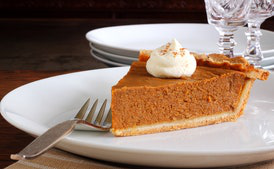

In [0]:
print(query_image_path)
Image.open(query_image_path).convert('RGB').show()

And here are the results of that search:

/dbfs/mnt/image_embeddings/dataset/images/spiced-pumpkin-phyllo-pie-355230.jpg


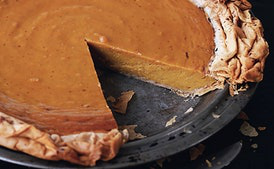



/dbfs/mnt/image_embeddings/dataset/images/spiced-pumpkin-pie-100401.jpg


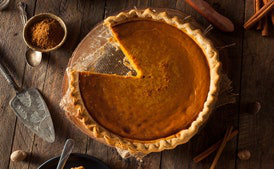



/dbfs/mnt/image_embeddings/dataset/images/the-ultimate-pumpkin-pie-826.jpg


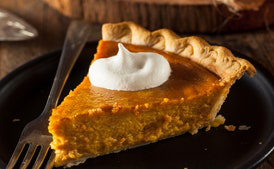

In [0]:
for r in results:
  image = Image.open(r['image_path']).convert('RGB')
  print(r['image_path'])
  image.show()
  print('\n')

One last thing to note about the sentence-transformers model we are using is that its embeddings have been built on a combination of image data as well as descriptive text. This allows us to search for images not just based on a supplied image but also free form text that a user may provide.  The model we are using is innovative enough that we can simply pass the text in to create the embedding and do our search as before.  In fact, we don't need to rewrite our function at all.  That said, you can see the results do differ a bit and are not quite as accurate as the image based search:

In [0]:
search_text = "pumpkin pie"

results = search(search_text)

display(results)

corpus_id,id,image_path,score
50,8410,/dbfs/mnt/image_embeddings/dataset/images/spiced-pumpkin-phyllo-pie-355230.jpg,0.3144124746322632
2110,10476,/dbfs/mnt/image_embeddings/dataset/images/sweet-potato-pie-with-marshmallow-meringue-240425.jpg,0.31214702129364014
13167,13207,/dbfs/mnt/image_embeddings/dataset/images/pumpkin-pie-102601.jpg,0.31210631132125854


/dbfs/mnt/image_embeddings/dataset/images/spiced-pumpkin-phyllo-pie-355230.jpg


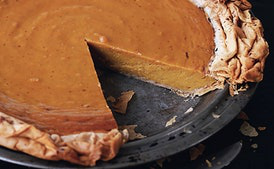



/dbfs/mnt/image_embeddings/dataset/images/sweet-potato-pie-with-marshmallow-meringue-240425.jpg


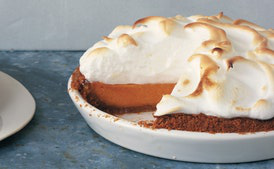



/dbfs/mnt/image_embeddings/dataset/images/pumpkin-pie-102601.jpg


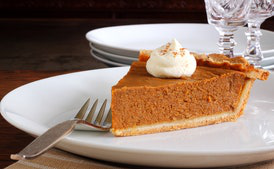

In [0]:
for r in results:
  image = Image.open(r['image_path']).convert('RGB')
  print(r['image_path'])
  image.show()
  print('\n')

&copy; 2022 Databricks, Inc. All rights reserved. The source in this notebook is provided subject to the [Databricks License](https://databricks.com/db-license-source).  All included or referenced third party libraries are subject to the licenses set forth below.

| library                                | description             | license    | source                                              |
|----------------------------------------|-------------------------|------------|-----------------------------------------------------|
|sentence-transformers | Provides an easy method to compute dense vector representations for sentences, paragraphs, and images | Apache 2.0| https://pypi.org/project/sentence-transformers/      |
| kaggle| Official API for https://www.kaggle.com, accessible using a command line tool implemented in Python | Apache 2.0 | https://pypi.org/project/kaggle/|